## Trabajo Final Estadística No Paramétrica
Alejandro Barrientos, Juan Fernando Gallego, Juan Pablo Restrepo Lopera, Omar Alejandro Henao Zapata, Ricardo Morris

## Librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

## Funciones

### Tipo de Kernel

In [ ]:
def kind_kernel(kind):

  '''Esta funcion permite elegir el tipo de kernel a usar en la estimacion
  de densidad. Recibe un string kind para elegir entre un kernel boxcar, 
  uno gaussian, uno epanechnikov y uno tricube. 
  La funcion entrega una funcion lambda a la que solo se la pasa el parámetro
  que se evaluara en el kernel indicado. Para mas informacion remitirse a 
  las paginas 51 - 54 de mis notas del curso de estadistica no parametrica
  y a las paginas 55 y 135 del libro de estadistica no parametrica de Wasermann.
  
  ------------------
  Parameters:
  kind: str
    str que indica el tipo de kernel a usar, puede ser boxcar, gaussian, 
    epanechnikov o tricube.
    
  ------------------
  Returns:
  kernel: lambda function
    funcion lambda que representa el kernel. Para evaluarla solo hay que hacer:

      #declarar el kernel
      kernel = kind_kernel(kind = "uno de los kernel disponibles")
      #evaluar el kernel en un punto w
      kernel(w)

  '''

  #funcion indicadora
  def function_I(z):
    return np.where(abs(z) <= 1, 1, 0)

  #asignacion del kernel
  if kind == 'boxcar':
    kernel = lambda w: 0.5 * function_I(z = w)
  elif kind == 'gaussian':
    kernel = lambda w: (1/np.sqrt(2*np.pi)) * np.exp(-(w**2)/2)
  elif kind == 'epanechnikov':
    kernel = lambda w: (3/4) * (1 - (w**2)) * function_I(z = w)
  elif kind == 'tricube':
    kernel = lambda w: (70/81) * ((1 - (abs(w)**3))**3) * function_I(z = w)
  elif kind == 'paper': #https://www.sciencedirect.com/science/article/pii/S0165176520301105
    cte_k0 = (1/(np.sqrt(8*np.pi*np.exp(1)) * norm.cdf(1, loc = 0, scale = 1)))
    k_0 = lambda w:  cte_k0* np.exp(-(1/2)*((np.log(1 + abs(w)))**2))
    omega = 0.5
    kernel = lambda w: omega * k_0(w) + (1 - omega) * norm.pdf(w, loc = 0, scale = 1)
  return kernel

### Regresión No Paramétrica

In [ ]:
def non_parametric_regresion(X_train, y_train, X_pred, 
                             kind_of_kernel = 'gaussian', h = 'auto'):

  '''Esta funcion realiza regresion no paramétrica empleando el estimador
  de Nadaraya-Watson. Se permite la seleccion del tipo de kernel entre 
  boxcar, gaussian, epanechnikov o tricube.  La escogencia del ancho de banda 
  puede ser automatica 'auto' o el usuario puede entregar directamente el 
  numero que representa el ancho de banda. Si el calculo es automatico emplea 
  la regla de Scott.
  A su vez, el usuario puede no solo interpolar sino también extrapolar, 
  gracias a la incorporacion del parámetro X_pred.
  Cualquier duda revisar: página 57 de mis notas del curso de estadistica
  no parametrica o la pagina 71 del libro de estadistica no parametrica
  de Wasserman.
  
  ----------------
  Parameters:
  X_train: 1-D numpy array
    numpy array que corresponde a los datos de entrenamiento de la 
    variable independiente
  y_train: 1-D numpy array
    numpy array que corresponde a los datos de entrenamiento de la 
    variable dependiente
  X_pred: 1-D numpy array
    numpy array que corresponde a los datos de la variable independiente 
    con los que se realizaran las predicciones de la variable dependiente. 
    Puede ser igual a X_train si solo se desea interpolar o bien puede ser 
    una muestra out of sample si se desea extrapolar, etc.
  kind_of_kernel: str
    str que indica el tipo de kernel a usar, puede ser boxcar, gaussian, 
    epanechnikov o tricube.
  h: str or float
    Si es str == 'auto' usa la regla de Scott para establecer el valor h
    para el calculo del ancho de banda, si es float corresponde al valor
    del ancho de banda.

  --------------
  Returns:
  y_pred: 1-D numpy array
    numpy array que corresponde a la prediccion de los valores de la variable
    dependiente para cada uno de los valores de X_pred.

  '''
  
  #lista para guardar las predicciones
  y_pred = []
  #longitud de los datos de entrenamiento
  n = len(X_train)
  #seleccion del kernel
  kernel = kind_kernel(kind = kind_of_kernel)
  #seleccion automatica del valor de h si corresponde
  if h == 'auto':
    sample_std = np.std(X_train)
    sample_IQR = np.quantile(X_train, 0.75) - np.quantile(X_train, 0.25)
    sigma = min(sample_std, sample_IQR/1.34)
    h = 1.06 * sigma / np.power(n, 1/5)
  #predicciones con el Nadaraya-Watson
  for x_pred in X_pred:
    K = kernel((X_train - x_pred)/h)
    denominator = np.sum(K)
    L = K / denominator
    y_pred.append(np.dot(L, y_train))
  y_pred = np.array(y_pred)

  return y_pred

### Cross-Validation Regresión No Paramétrica

In [ ]:
def non_parametric_regresion_cv(X, y, k_folds = 5, shuffle = True, metric = 'MAE',
                                kind_of_kernel = 'gaussian', h = 'auto'):
    
    '''Esta función realiza regresión no paramétrica empleando el 
    estimador de Nadaraya-Watson, con validaciópn cruzada de k folios 
    para obtener una puntuación promedio de los valores de cada folio 
    de la métrica seleccionada.
    ----------------
  Parameters:
  X: 1-D numpy array
    numpy array que corresponde a los datos de la
    variable independiente
  y: 1-D numpy array
    numpy array que corresponde a los datos de la 
    variable dependiente
  k_folds: integer, por defecto es 5.
    Número de divisiones a realizar en la validación cruzada.
  shuffle: boolean, por defecto es True.
    Ya sea para mezclar los datos antes de dividirlos en folios.
  metric: str, por defecto es 'MAE'
    Tipo de métrica a evaluar
  kind_of_kernel: str, por defecto es 'gaussian'.
    str que indica el tipo de kernel a usar, puede ser boxcar, gaussian, 
    epanechnikov o tricube.
  h: str or float, por defecto es 'auto'.
    Si es str == 'auto' usa la regla de Scott para establecer el valor h
    para el calculo del ancho de banda, si es float corresponde al valor
    del ancho de banda.

  --------------
  Returns:
  Promedio METRICS: float
    Promedio de la respectiva métrica calculada para cada folio en el proceso

    '''

    #Convertir a dataframe
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    #Mezclar
    if shuffle == True:
        rows = len(X)
        shuffle_index = np.random.choice(rows, rows, replace=False)
        X = X.iloc[shuffle_index].copy(deep = True)
        y = y.iloc[shuffle_index].copy(deep = True)
    #Dividir conjunto de datos en k-folios
    X_folds = np.array_split(X, k_folds)
    y_folds = np.array_split(y, k_folds)
    
    #Métrica a evaluar
    if metric == 'MAE':
        metric_function = lambda x_vals, y_vals:  mean_absolute_error(x_vals, y_vals)
    elif metric == 'MSE':
        metric_function = lambda x_vals, y_vals:  mean_squared_error(x_vals, y_vals)
    #Declarar lista para almacenar métricas
    METRICS = []
    for f in range(len(X_folds)):
        # Crear conjuntos de entrenamiento y testeo, transformados como 1-D arreglos
        X_test  = X_folds[f].values.reshape(-1)
        y_test  = y_folds[f].values.reshape(-1)
        X_train = X.drop(X_folds[f].index).values.reshape(-1)
        y_train = y.drop(y_folds[f].index).values.reshape(-1)
        # Entrenar modelo
        y_pred_test = non_parametric_regresion(X_train = X_train, 
                                               y_train = y_train,
                                               X_pred = X_test, 
                                               kind_of_kernel = kind_of_kernel, 
                                               h = h)
        # Medir métrica
        METRICS.append(metric_function(y_test, y_pred_test))
    #Retornar promedio de METRICS
    return np.mean(METRICS)

### Generador de Submuestras

In [ ]:
def sub_samples_generator(sample):

  '''Esta funcion es capaz de generar una muestra con reemplazo a partir de un
  pandas Series, un pandas DataFrame o un numpy array de una dimension. 
  
  ------------------
  Parameters:
  sample: pd.core.series.Series, pd.core.frame.DataFrame o np.array of 1D
    muestra de la que se realizara el submuestreo con reemplazo
  
  Returns:
  un objeto pd.core.series.Series, pd.core.frame.DataFrame o np.array of 1D
  que corresponde a una submuestra con reemplazo'''

  if type(sample) == pd.core.series.Series:
    return sample.iloc[np.random.randint(low = 0, high = len(sample), size = len(sample))]
  elif type(sample) == pd.core.frame.DataFrame:
    return sample.iloc[np.random.randint(low = 0, high = len(sample), size = len(sample)), :]
  elif type(sample) == np.ndarray and len(sample.shape) == 1:
    return np.random.choice(sample, len(sample), replace = True)

### Bagging Nadaraya Watson

In [ ]:
def bagging_nadaraya_watson(X_train, y_train, 
                            X_pred, kind_of_kernel = 'epanechnikov', 
                            h = 1.1, n_estimators = 100, model = 'mean'):

    dicc_models = {} #Diccionario para almacenar los modelos bootstrap. Se usa X_train y y_train para las submuestras

    for i in range(0, n_estimators):
        random_indexes = np.sort(np.random.randint(low = 0, #Esto genera n números aleatorios entre un intervalo de manera uniforme, lo que implica que uno de los índices podría repetirse (reemplazo)
                                                    high = len(X_train), 
                                                    size = len(X_train)))
        X_train_sub_i = X_train[random_indexes]
        y_train_sub_i = y_train[random_indexes]
        y_pred_sub_i = non_parametric_regresion(X_train = X_train_sub_i, 
                                                y_train = y_train_sub_i, 
                                                X_pred = X_pred, 
                                                kind_of_kernel = kind_of_kernel, h = h)
        dicc_models[i] = y_pred_sub_i

    data = pd.DataFrame(dicc_models.values(), columns = X_pred)

    if model == 'mean':
        y_pred = data.mean(axis = 0)
    elif model == 'median':
        y_pred = data.median(axis = 0)
    elif model == 'functional_median':
        y_pred = data.iloc[sm.graphics.fboxplot(data, wfactor = 1)[2][0]]
        plt.close()
    
    return y_pred

### Cross-Validation Bagging Regresión No Paramétrica

In [ ]:
def bagging_nadaraya_watson_cv(X, y, k_folds = 5, shuffle = True, metric = 'MAE',
                               kind_of_kernel = 'gaussian', h = 'auto',
                               n_estimators = 100, model = 'mean'):
    
    '''Esta función realiza bagging sobre la regresión no paramétrica 
    empleando el estimador de Nadaraya-Watson, con validaciópn cruzada de
    k folios para obtener una puntuación promedio de los valores de cada folio 
    de la métrica seleccionada.
    ----------------
  Parameters:
  X: 1-D numpy array
    numpy array que corresponde a los datos de la
    variable independiente
  y: 1-D numpy array
    numpy array que corresponde a los datos de la 
    variable dependiente
  k_folds: integer, por defecto es 5.
    Número de divisiones a realizar en la validación cruzada
  shuffle: boolean, por defecto es True.
    Ya sea para mezclar los datos antes de dividirlos en folios.
  metric: str, por defecto es 'MAE'
    Tipo de métrica a evaluar
  kind_of_kernel: str, por defecto es 'gaussian'.
    str que indica el tipo de kernel a usar, puede ser boxcar, gaussian, 
    epanechnikov o tricube.
  h: str or float, por defecto es 'auto'.
    Si es str == 'auto' usa la regla de Scott para establecer el valor h
    para el calculo del ancho de banda, si es float corresponde al valor
    del ancho de banda.
  n_estimators: int, por defecto es 100.
    Número de estimadores en el proceso de Bagging.
  model: str, por defecto es 'mean'.
    Tipo de estimación, puede ser promedio (mean) o mediana (median)

  --------------
  Returns:
  Promedio METRICS: float
    Promedio de los MAEs calculados en el proceso

    '''

    #Convertir a dataframe
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    #Mezclar
    if shuffle == True:
        rows = len(X)
        shuffle_index = np.random.choice(rows, rows, replace=False)
        X = X.iloc[shuffle_index].copy(deep = True)
        y = y.iloc[shuffle_index].copy(deep = True)
    #Dividir conjunto de datos en k-folios
    X_folds = np.array_split(X, k_folds)
    y_folds = np.array_split(y, k_folds)
    
    #Métrica a evaluar
    if metric == 'MAE':
        metric_function = lambda x_vals, y_vals:  mean_absolute_error(x_vals, y_vals)
    elif metric == 'MSE':
        metric_function = lambda x_vals, y_vals:  mean_squared_error(x_vals, y_vals)
    #Declarar lista para almacenar métricas
    train_err = []
    test_err = []
    for f in range(len(X_folds)):
        # Crear conjuntos de entrenamiento y testeo, transformados como 1-D arreglos
        X_test  = X_folds[f].values.reshape(-1)
        y_test  = y_folds[f].values.reshape(-1)
        X_train = X.drop(X_folds[f].index).values.reshape(-1)
        y_train = y.drop(y_folds[f].index).values.reshape(-1)
        # Entrenar modelo en testeo
        y_pred_test = bagging_nadaraya_watson(X_train = X_train, 
                                              y_train = y_train, 
                                              X_pred = X_test, 
                                              kind_of_kernel = kind_of_kernel, 
                                              h = h, 
                                              n_estimators = n_estimators, 
                                              model = model)
        
        # Entrenar modelo en training
        #y_pred_train = bagging_nadaraya_watson(X_train = X_train, 
        #                                      y_train = y_train, 
        #                                      X_pred = X_train, 
        #                                      kind_of_kernel = kind_of_kernel, 
        #                                      h = h, 
        #                                      n_estimators = n_estimators, 
        #                                      model = model)
        # Medir métrica
        #train_err.append(metric_function(y_train, y_pred_train))
        test_err.append(metric_function(y_test, y_pred_test))
    #Retornar promedio de errores
    return np.mean(test_err)

### Comparacion de Kernels

In [ ]:
def comparacion_kernels(x_train_prueba, y_train_prueba): 
    y_pred_prueba_paper = non_parametric_regresion(X_train = x_train_prueba, y_train = y_train_prueba, 
    X_pred = x_train_prueba, kind_of_kernel = 'paper', h = 'auto')
    y_pred_prueba_gaussian = non_parametric_regresion(X_train = x_train_prueba, y_train = y_train_prueba, 
    X_pred = x_train_prueba, kind_of_kernel = 'gaussian', h = 'auto')
    y_pred_prueba_epane = non_parametric_regresion(X_train = x_train_prueba, y_train = y_train_prueba, 
    X_pred = x_train_prueba, kind_of_kernel = 'epanechnikov', h = 'auto')
    y_pred_prueba_epane_bagging = bagging_nadaraya_watson(X_train = x_train_prueba, y_train = y_train_prueba, 
    X_pred = x_train_prueba, kind_of_kernel = 'epanechnikov', h = 'auto', n_estimators = 100, model = 'median').values

    plt.plot(x_train_prueba, y_pred_prueba_paper, color = 'r', linewidth = 2, label = 'paper');
    plt.plot(x_train_prueba, y_pred_prueba_gaussian, color = 'k', linewidth = 2, label = 'gaussian');
    plt.plot(x_train_prueba, y_pred_prueba_epane, color = 'g', linewidth = 2, label = 'epanechnikov');
    plt.plot(x_train_prueba, y_pred_prueba_epane_bagging, color = 'y', linewidth = 2, label = 'bagging epanechnikov');

    plt.legend();
    plt.scatter(x_train_prueba, y_train_prueba);

### Grid Search Bagging 

In [ ]:
def grid_search_bagging(X, y, model, kind_of_kernel = 'paper', k_folds = 5):
    
    sample_std = np.std(X)
    sample_IQR = np.quantile(X, 0.75) - np.quantile(X, 0.25)
    sigma = min(sample_std, sample_IQR/1.34)
    h_scott = 1.06 * sigma / np.power(len(X), 1/5)
    H = np.linspace(start = h_scott*0.05, stop = h_scott*1.5, num = 40) #en start estaba en 0.08*scott 

    #error_list = []

    error_list_train = []
    error_list_test = []

    for h in H:

        #error_list.append(bagging_nadaraya_watson_cv(X = X, y = y, k_folds = 20, 
        #                        kind_of_kernel = 'gaussian', h = h, 
        #                        n_estimators = 100, model = model, metric = 'MSE'))
        
        error_test = bagging_nadaraya_watson_cv(X = X, y = y, k_folds = k_folds, 
                                kind_of_kernel = kind_of_kernel, h = h, 
                                n_estimators = 100, model = model, metric = 'MSE')

        #error_list_train.append(error_train)
        error_list_test.append(error_test)
    
    #return H[np.argmin(error_list)], h_scott
    return H, error_list_test


## Pruebas

### Desempeño de los kernel

Función 1

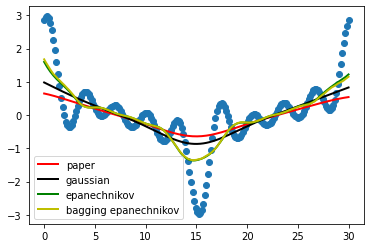

In [ ]:
#X = np.linspace(start = 1, stop = 50, num = 200)
X = np.linspace(start = 0, stop = 30, num = 200)
#Y = 20*np.log(X+1) - 0.01*np.power(X, 2) + 10 + 2*np.random.normal(loc = 0, scale = 1, size = len(X)) + 14*np.cos(X)


#Y = 3*np.random.normal(loc = 0, scale = 1, size = len(X)) + np.power(X, 3) + np.power(X, 2) 
th = X
f = lambda th: np.cos(th*2*np.pi/30)
Y = f(th)+0.5*f(3*th+0.23)+0.5*f(5*th-0.4)+0.5*f(7*th-2.09)+0.5*f(9*th-3)

comparacion_kernels(x_train_prueba = X, y_train_prueba = Y)


Función 2

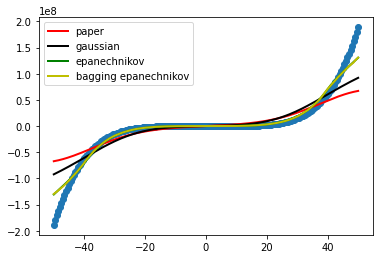

In [ ]:
X = np.linspace(start = -50, stop = 50, num = 200)

Y = 0.6*np.power(X,5)+10*np.power(X,3)-5*np.power(X,2)

comparacion_kernels(x_train_prueba = X, y_train_prueba = Y)


Función 3

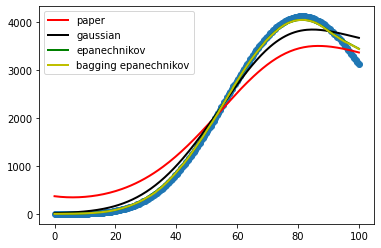

In [ ]:
X = np.linspace(start = 0, stop = 100, num = 200)

Y =  np.power(X,3)*(1/(np.sqrt(2*np.pi*np.cov(X))))*np.exp(-1*np.power((X-np.mean(X)),2)/(2*np.cov(X)))

comparacion_kernels(x_train_prueba = X, y_train_prueba = Y)

Función 4

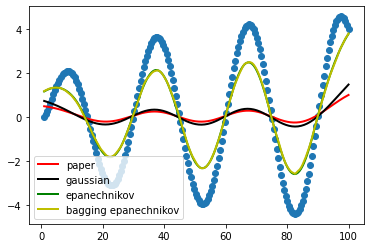

In [ ]:
X = np.linspace(start = 1, stop = 100, num = 200)

Y =  np.log(X)*np.sin(X/30*2*np.pi)

comparacion_kernels(x_train_prueba = X, y_train_prueba = Y)

Función 5

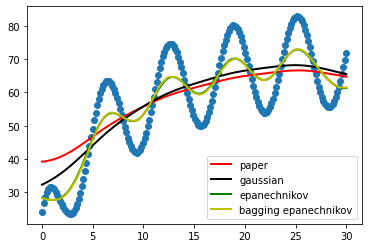

In [ ]:
X = np.linspace(start = 0, stop = 30, num = 200)
Y = 20*np.log(X+1) - 0.01*np.power(X, 2) + 10 + 14*np.cos(X)

comparacion_kernels(x_train_prueba = X, y_train_prueba = Y)

Función 6

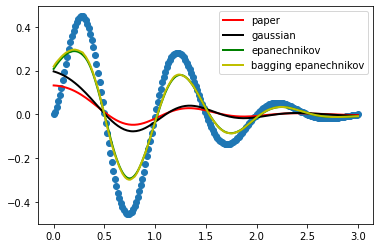

In [ ]:
X = np.linspace(start = 0, stop = 3, num = 200)
Y = np.power(X,1/2)*np.exp(-1*np.power(X,3/2))*np.sin(2*np.pi*X)

comparacion_kernels(x_train_prueba = X, y_train_prueba = Y)

### Comparación de errores out-of-sample con h optimizado con cross-validation y bagging que usa la media punto a punto, más un kernel robusto.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Out-of-sample error proposed:  0.5622545763884053
Out-of-sample error usual:  0.7813959067657442


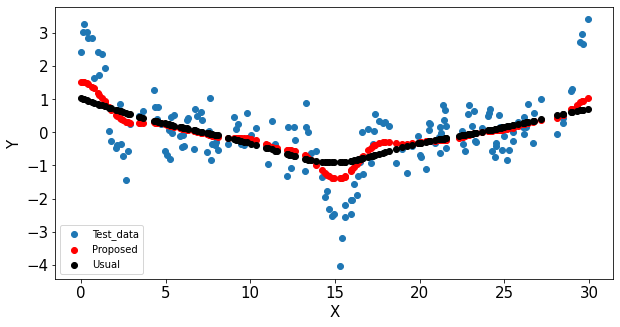

In [ ]:
#Funcion 1 

#Datos
X = np.linspace(start = 0, stop = 30, num = 600)
th = X
f = lambda th: np.cos(th*2*np.pi/30)
Y = f(th)+0.5*f(3*th+0.23)+0.5*f(5*th-0.4)+0.5*f(7*th-2.09)+0.5*f(9*th-3) + 0.5*np.random.normal(loc = 0, scale = 1, size = len(X))


#Dividir datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
#Ejecutar modelo
hs_mean, mean_test_error = grid_search_bagging(X = X_train, y = Y_train, model = 'mean')

#Resultados en test propuesta
y_pred_validation = bagging_nadaraya_watson(X_train, Y_train, X_test,
                                            kind_of_kernel='paper',
                                            h = hs_mean[np.argmin(mean_test_error)],
                                            n_estimators = 100,
                                            model = 'mean')
print('Out-of-sample error proposed: ', mean_squared_error(Y_test, y_pred_validation))

#Resultados en test usual
y_pred_scott = non_parametric_regresion(X_train, Y_train, X_test,
                                        kind_of_kernel='gaussian',
                                        h = 'auto')
print('Out-of-sample error usual: ', mean_squared_error(Y_test, y_pred_scott))

#Gráfico
plt.figure(figsize=(10, 5))
plt.scatter(X_test, Y_test, label = 'Test_data')
plt.scatter(X_test, y_pred_validation, color = 'r', label = 'Proposed')
plt.scatter(X_test, y_pred_scott, color = 'k', label = 'Usual')
plt.ylabel('Y', fontsize = 15);
plt.xlabel('X', fontsize = 15);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.legend(fontsize = 10);
#Guardar figura
plt.savefig('exp1.eps')

Out-of-sample error proposed:  513507246662570.56
Out-of-sample error usual:  763908132362073.2
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


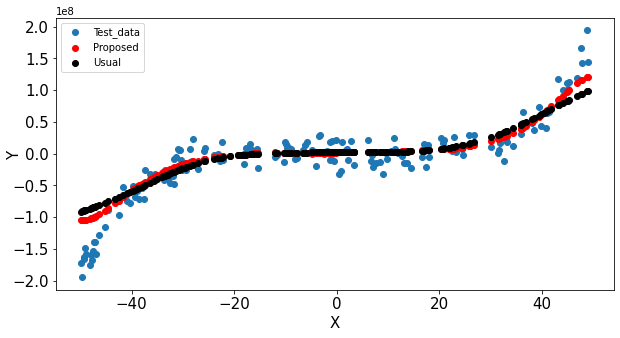

In [ ]:
#Funcion 2

#Datos
X = np.linspace(start = -50, stop = 50, num = 600)
Y = 0.6*np.power(X,5)+10*np.power(X,3)-5*np.power(X,2)+np.random.normal(loc = 0, scale = 1.5e7, size = len(X))

#Dividir datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
#Ejecutar modelo
hs_mean, mean_test_error = grid_search_bagging(X = X_train, y = Y_train, model = 'mean')

#Resultados en test propuesta
y_pred_validation = bagging_nadaraya_watson(X_train, Y_train, X_test,
                                            kind_of_kernel='paper',
                                            h = hs_mean[np.argmin(mean_test_error)],
                                            n_estimators = 100,
                                            model = 'mean')
print('Out-of-sample error proposed: ', mean_squared_error(Y_test, y_pred_validation))

#Resultados en test usual
y_pred_scott = non_parametric_regresion(X_train, Y_train, X_test,
                                        kind_of_kernel='gaussian',
                                        h = 'auto')
print('Out-of-sample error usual: ', mean_squared_error(Y_test, y_pred_scott))

#Gráfico
plt.figure(figsize=(10, 5))
plt.scatter(X_test, Y_test, label = 'Test_data')
plt.scatter(X_test, y_pred_validation, color = 'r', label = 'Proposed')
plt.scatter(X_test, y_pred_scott, color = 'k', label = 'Usual')
plt.ylabel('Y', fontsize = 15, labelpad = -10);
plt.xlabel('X', fontsize = 15);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.legend(fontsize = 10);
#Guardar figura
plt.savefig('exp2.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Out-of-sample error proposed:  110.7768440035095
Out-of-sample error usual:  680.6391091374239


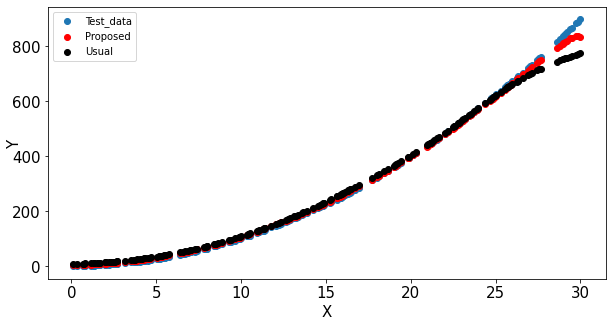

In [ ]:
#Funcion 3

#Datos
X = np.linspace(start = 0, stop = 30, num = 600)
th = X
f = lambda th: np.sin(th*2*np.pi/30)
Y = np.power(th, 2) + f(th)+f(3*th+0.23)+0.5*f(5*th-0.4)+0.5*f(th-2.09)+0.5*f(th-3) + 0.5*np.random.normal(loc = 0, scale = 1, size = len(X))

#Dividir datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
#Ejecutar modelo
hs_mean, mean_test_error = grid_search_bagging(X = X_train, y = Y_train, model = 'mean')

#Resultados en test propuesta
y_pred_validation = bagging_nadaraya_watson(X_train, Y_train, X_test,
                                            kind_of_kernel='paper',
                                            h = hs_mean[np.argmin(mean_test_error)],
                                            n_estimators = 100,
                                            model = 'mean')
print('Out-of-sample error proposed: ', mean_squared_error(Y_test, y_pred_validation))

#Resultados en test usual
y_pred_scott = non_parametric_regresion(X_train, Y_train, X_test,
                                        kind_of_kernel='gaussian',
                                        h = 'auto')
print('Out-of-sample error usual: ', mean_squared_error(Y_test, y_pred_scott))

#Gráfico
plt.figure(figsize=(10, 5))
plt.scatter(X_test, Y_test, label = 'Test_data')
plt.scatter(X_test, y_pred_validation, color = 'r', label = 'Proposed')
plt.scatter(X_test, y_pred_scott, color = 'k', label = 'Usual')
plt.ylabel('Y', fontsize = 15, labelpad = -10);
plt.xlabel('X', fontsize = 15);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.legend(fontsize = 10);
#Guardar figura
plt.savefig('exp3.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Out-of-sample error proposed:  1.7484796792464123
Out-of-sample error usual:  5.806227389004541


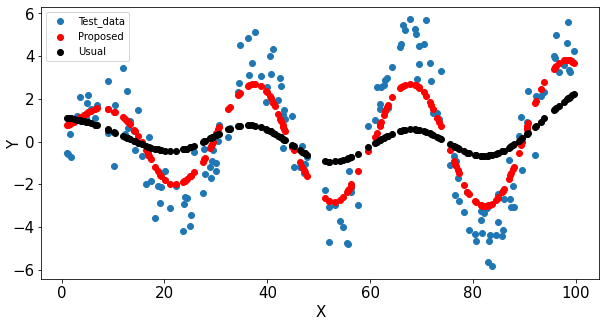

In [ ]:
#Funcion 4

X = np.linspace(start = 1, stop = 100, num = 600)

Y =  np.log(X)*np.sin(X/30*2*np.pi) +  np.random.normal(0, 1,len(X))

#Dividir datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
#Ejecutar modelo
hs_mean, mean_test_error = grid_search_bagging(X = X_train, y = Y_train, model = 'mean')

#Resultados en test propuesta
y_pred_validation = bagging_nadaraya_watson(X_train, Y_train, X_test,
                                            kind_of_kernel='paper',
                                            h = hs_mean[np.argmin(mean_test_error)],
                                            n_estimators = 100,
                                            model = 'mean')
print('Out-of-sample error proposed: ', mean_squared_error(Y_test, y_pred_validation))

#Resultados en test usual
y_pred_scott = non_parametric_regresion(X_train, Y_train, X_test,
                                        kind_of_kernel='gaussian',
                                        h = 'auto')
print('Out-of-sample error usual: ', mean_squared_error(Y_test, y_pred_scott))

#Gráfico
plt.figure(figsize=(10, 5))
plt.scatter(X_test, Y_test, label = 'Test_data')
plt.scatter(X_test, y_pred_validation, color = 'r', label = 'Proposed')
plt.scatter(X_test, y_pred_scott, color = 'k', label = 'Usual')
plt.ylabel('Y', fontsize = 15, labelpad = -10);
plt.xlabel('X', fontsize = 15);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.legend(fontsize = 10);
#Guardar figura
plt.savefig('exp4.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Out-of-sample error proposed:  100.30097019834453
Out-of-sample error usual:  145.40862469733472


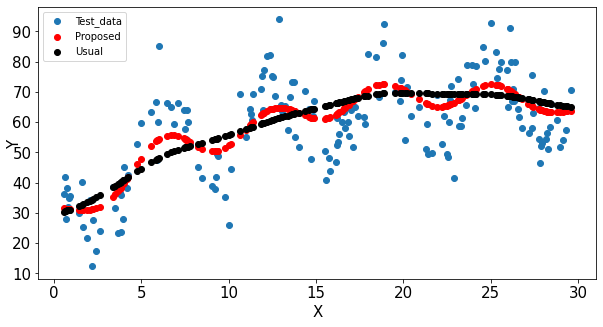

In [ ]:
#Funcion 5
X = np.linspace(start = 0, stop = 30, num = 600)

Y = 20*np.log(X+1) - 0.01*np.power(X, 2) + 10 + 14*np.cos(X)+np.random.normal(0,8,len(X))

#Dividir datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
#Ejecutar modelo
hs_mean, mean_test_error = grid_search_bagging(X = X_train, y = Y_train, model = 'mean')

#Resultados en test propuesta
y_pred_validation = bagging_nadaraya_watson(X_train, Y_train, X_test,
                                            kind_of_kernel='paper',
                                            h = hs_mean[np.argmin(mean_test_error)],
                                            n_estimators = 100,
                                            model = 'mean')
print('Out-of-sample error proposed: ', mean_squared_error(Y_test, y_pred_validation))

#Resultados en test usual
y_pred_scott = non_parametric_regresion(X_train, Y_train, X_test,
                                        kind_of_kernel='gaussian',
                                        h = 'auto')
print('Out-of-sample error usual: ', mean_squared_error(Y_test, y_pred_scott))

#Gráfico
plt.figure(figsize=(10, 5))
plt.scatter(X_test, Y_test, label = 'Test_data')
plt.scatter(X_test, y_pred_validation, color = 'r', label = 'Proposed')
plt.scatter(X_test, y_pred_scott, color = 'k', label = 'Usual')
plt.ylabel('Y', fontsize = 15, labelpad = -10);
plt.xlabel('X', fontsize = 15);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.legend(fontsize = 10);
#Guardar figura
plt.savefig('exp5.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Out-of-sample error proposed:  15.012071285278731
Out-of-sample error usual:  33.258027537659956


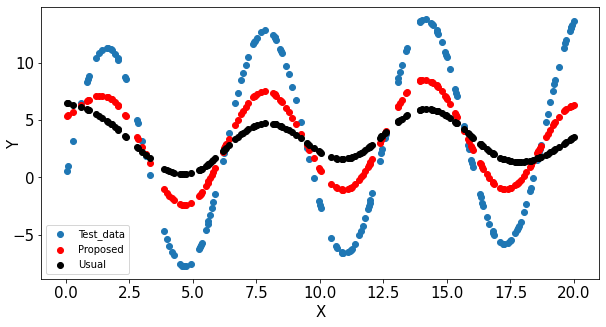

In [ ]:
#Funcion 6
X = np.linspace(start = 0, stop = 20, num = 600)
Y = np.power(X,1/2) + 10*np.sin(X) + np.random.normal(0,1)

#Dividir datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
#Ejecutar modelo
hs_mean, mean_test_error = grid_search_bagging(X = X_train, y = Y_train, model = 'mean')

#Resultados en test propuesta
y_pred_validation = bagging_nadaraya_watson(X_train, Y_train, X_test,
                                            kind_of_kernel='paper',
                                            h = hs_mean[np.argmin(mean_test_error)],
                                            n_estimators = 100,
                                            model = 'mean')
print('Out-of-sample error proposed: ', mean_squared_error(Y_test, y_pred_validation))

#Resultados en test usual
y_pred_scott = non_parametric_regresion(X_train, Y_train, X_test,
                                        kind_of_kernel='gaussian',
                                        h = 'auto')
print('Out-of-sample error usual: ', mean_squared_error(Y_test, y_pred_scott))

#Gráfico
plt.figure(figsize=(10, 5))
plt.scatter(X_test, Y_test, label = 'Test_data')
plt.scatter(X_test, y_pred_validation, color = 'r', label = 'Proposed')
plt.scatter(X_test, y_pred_scott, color = 'k', label = 'Usual')
plt.ylabel('Y', fontsize = 15, labelpad = -10);
plt.xlabel('X', fontsize = 15);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.legend(fontsize = 10);
#Guardar figura
plt.savefig('exp6.eps')


In [ ]:
plt.rcParams["figure.figsize"] = (12,9)

## Comparación con todos los datos full hd 4k 1 link español

Out-of-sample error proposed:  0.00036342179766274575
Out-of-sample error usual:  0.026356091441680506
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


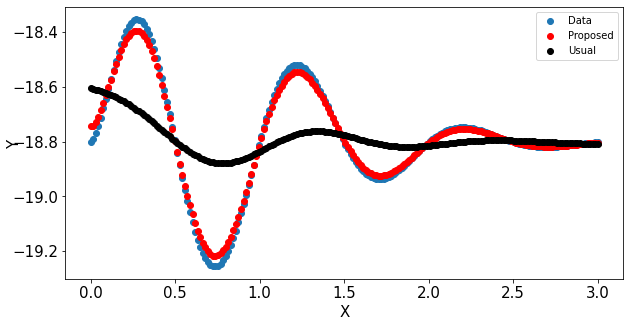

In [ ]:
X = np.linspace(start = 0, stop = 3, num = 200)
Y = np.power(X,1/2)*np.exp(-1*np.power(X,3/2))*np.sin(2*np.pi*X) + np.random.normal(0, 10)

#Ejecutar modelo
hs_mean, mean_test_error = grid_search_bagging(X = X, y = Y, model = 'mean')

#Resultados en test propuesta
y_pred_validation = bagging_nadaraya_watson(X, Y, X,
                                            kind_of_kernel='paper',
                                            h = hs_mean[np.argmin(mean_test_error)],
                                            n_estimators = 100,
                                            model = 'mean')
print('Out-of-sample error proposed: ', mean_squared_error(Y, y_pred_validation))

#Resultados en test usual
y_pred_scott = non_parametric_regresion(X, Y, X,
                                        kind_of_kernel='gaussian',
                                        h = 'auto')
print('Out-of-sample error usual: ', mean_squared_error(Y, y_pred_scott))

#Gráfico
plt.figure(figsize=(10, 5))
plt.scatter(X, Y, label = 'Data')
plt.scatter(X, y_pred_validation, color = 'r', label = 'Proposed')
plt.scatter(X, y_pred_scott, color = 'k', label = 'Usual')
plt.ylabel('Y', fontsize = 15, labelpad = -10);
plt.xlabel('X', fontsize = 15);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.legend(fontsize = 10);

plt.savefig('total_exp1.eps')

Out-of-sample error proposed:  274.8825256004288
Out-of-sample error usual:  34593.41756536973
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


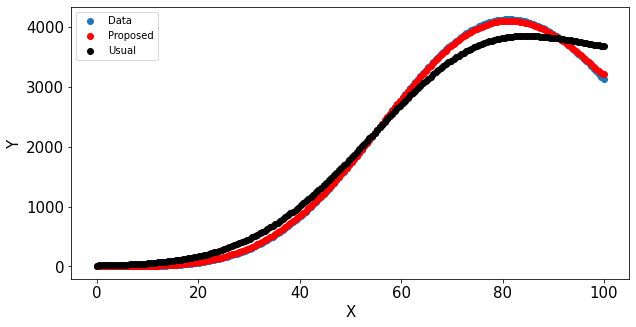

In [ ]:
X = np.linspace(start = 0, stop = 100, num = 200)
Y =  np.power(X,3)*(1/(np.sqrt(2*np.pi*np.cov(X))))*np.exp(-1*np.power((X-np.mean(X)),2)/(2*np.cov(X))) + np.random.normal(0, 10)

#Ejecutar modelo
hs_mean, mean_test_error = grid_search_bagging(X = X, y = Y, model = 'mean')

#Resultados en test propuesta
y_pred_validation = bagging_nadaraya_watson(X, Y, X,
                                            kind_of_kernel='paper',
                                            h = hs_mean[np.argmin(mean_test_error)],
                                            n_estimators = 100,
                                            model = 'mean')
print('Out-of-sample error proposed: ', mean_squared_error(Y, y_pred_validation))

#Resultados en test usual
y_pred_scott = non_parametric_regresion(X, Y, X,
                                        kind_of_kernel='gaussian',
                                        h = 'auto')
print('Out-of-sample error usual: ', mean_squared_error(Y, y_pred_scott))

#Gráfico
plt.figure(figsize=(10, 5))
plt.scatter(X, Y, label = 'Data')
plt.scatter(X, y_pred_validation, color = 'r', label = 'Proposed')
plt.scatter(X, y_pred_scott, color = 'k', label = 'Usual')
plt.ylabel('Y', fontsize = 15);
plt.xlabel('X', fontsize = 15);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.legend(fontsize = 10);

plt.savefig('total_exp2.eps')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=632214ee-c193-4710-b203-1f42c76f0ae1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>